In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Load Metadata
df1 = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)
meta_df = df1[['floor_area', 'wall_material','total_adults', 'total_children','monthly_income','water_access','roof_material','years_electrified']] # Select relevant features
meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature

# # Load gauss fit data
# data = pd.read_pickle('sorted_households.pkl') # Read pickle file
# # Read in only the sorted households, combine the dataframes with the sorted households features, perform clustering!!
# # Include the other finished bins that completed feature extraction

# df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
# df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
# df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
# df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
# df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
# df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# # Select all filtered households 
# df_50_150.loc[data['50_150']] 
# df_150_400.loc[data['150_400']]
# df_400_600.loc[data['400_600']] 
# df_600_1200.loc[data['600_1200']] 
# df_1200_2500.loc[data['1200_2500']] 

# # Combine all the data
# frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

# df2 = pd.DataFrame()
# df2 = df_50_150.append(frame)

<ipython-input-2-9e2ef8f686b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature


In [8]:
# data = pd.read_pickle('sorted_households.pkl') # Read pickle file

# Read in average monthly consumption data
X = pd.read_csv('AMC_dataframe.csv', index_col=['ProfileID'])
AMC_df = X.copy()

X.reset_index(inplace = True)
# # Extract household IDs
# household_ids = list(data.values())
# householdIDs =  [l.tolist() for l in household_ids]
# householdIDs = list(map(int, chain.from_iterable(householdIDs)))

#Select rows based on condition 
# AMC_df = X[X['ProfileID'].isin(householdIDs)] 

# AMC_df.set_index(['ProfileID'], inplace=True)


df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Select all filtered households 
# df_50_150.loc[data['50_150']] 
# df_150_400.loc[data['150_400']]
# df_400_600.loc[data['400_600']] 
# df_600_1200.loc[data['600_1200']] 
# df_1200_2500.loc[data['1200_2500']] 

# Combine all the data
frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

df = pd.DataFrame()
df = df_50_150.append(frame)

#Select rows based on condition 
df.reset_index(inplace=True)
df = df[df['ProfileID'].isin(AMC_df.index.values)]

df.set_index(['ProfileID'], inplace=True)


#Select rows based on conditio
AMC_df.reset_index(['ProfileID'], inplace=True)

AMC_df = X[X['ProfileID'].isin(df.index.values)] 

AMC_df.set_index(['ProfileID'], inplace=True)

# Load Metadata
df1 = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)
meta_df = df1[['floor_area', 'wall_material','total_adults', 'total_children','monthly_income','water_access','roof_material','years_electrified']] # Select relevant features
meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature

<ipython-input-8-a43162151590>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature


In [13]:
# Drop all NaN values from dataframe
meta_df = meta_df.dropna()

# Filter out only households with Gauss Fit that completed a survey
households_ids1 = AMC_df.index.to_list()
meta_df_filtered = meta_df.loc[meta_df.index.isin(households_ids1),:]

# # Filter out only households that completed a survey from Gauss Fit
households_ids2 = meta_df_filtered.index.to_list()
AMC_df_filtered = AMC_df.loc[AMC_df.index.isin(households_ids2),:]

In [14]:
meta_df_filtered

,floor_area,wall_material,total_adults,total_children,monthly_income,water_access,roof_material,years_electrified,total_residents
ProfileID,,,,,,,,,
121,50.0,Brick,5,2,23396.23,tap inside house,Asbestos,10.0,7
123,50.0,Brick,3,5,12452.83,tap inside house,Asbestos,10.0,8
126,50.0,Brick,3,1,5283.02,tap inside house,Asbestos,10.0,4
132,50.0,Brick,3,3,3207.55,tap inside house,Asbestos,10.0,6
135,50.0,Brick,2,2,3396.23,tap inside house,Asbestos,10.0,4
...,...,...,...,...,...,...,...,...,...
12029006,61.0,Plaster,3,1,9659.09,tap in yard,IBR/Corr.Iron/Zinc,2.0,4
12029010,59.0,Plaster,1,0,227.27,tap in yard,IBR/Corr.Iron/Zinc,30.0,1
12029019,132.0,Plaster,2,0,1022.73,tap inside house,IBR/Corr.Iron/Zinc,30.0,2


In [15]:
AMC_df_filtered

,AMC_winter,AMC_yearly
ProfileID,,
3,994.282506,569.030589
4,619.423681,404.916203
5,884.767180,510.245011
6,538.049648,331.499595
7,253.432005,290.748536
...,...,...
12029006,279.309869,240.705221
12029010,396.253795,415.556173
12029019,412.007433,448.671829


In [27]:
# Load the ids with complete winter months
import pickle

# save list of houeholds with complete winter months
with open("winter_months_ids", "rb") as fp:   # Unpickling
   winter_months_ids = pickle.load(fp)

# Filter out profiles with incomplete winter months
# Filter out only households with Gauss Fit that completed a survey
# households_ids1 = AMC_df.index.to_list()
meta_df_winter = meta_df_filtered.loc[meta_df_filtered.index.isin(winter_months_ids),:]

# # Filter out only households that completed a survey from Gauss Fit
# households_ids2 = meta_df_filtered.index.to_list()
AMC_df_winter = AMC_df_filtered.loc[AMC_df_filtered.index.isin(winter_months_ids),:]

### Create Encoded dataframe

In [16]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(meta_df_filtered['roof_material'])
meta_df_filtered['roof_material_ENC'] = enc.transform(meta_df_filtered['roof_material'])

enc.fit(meta_df_filtered['water_access'])
meta_df_filtered['water_access_ENC'] = enc.transform(meta_df_filtered['water_access'])

enc.fit(meta_df_filtered['wall_material'])
meta_df_filtered['wall_material_ENC'] = enc.transform(meta_df_filtered['wall_material'])

meta__df_encoded = meta_df_filtered[['floor_area', 'monthly_income','total_residents','roof_material_ENC','water_access_ENC','wall_material_ENC', 'years_electrified']]
encoded_df = pd.merge(meta__df_encoded,AMC_df, left_index = True,right_index=True)

<ipython-input-16-57e8268dde40>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_filtered['roof_material_ENC'] = enc.transform(meta_df_filtered['roof_material'])
<ipython-input-16-57e8268dde40>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_filtered['water_access_ENC'] = enc.transform(meta_df_filtered['water_access'])
<ipython-input-16-57e8268dde40>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Remove outliers in Gauss_fit dataframe

In [81]:
# Remove outliers

# Find absolute value of z-score for each observation
z = np.abs(stats.zscore(df2))

# #only keep rows in dataframe with all z-scores less than absolute value of 3 
df2 = df2[(z<3).all(axis=1)]

# Perform Linear Regression

### On all points

R2 = -0.18890668485382034


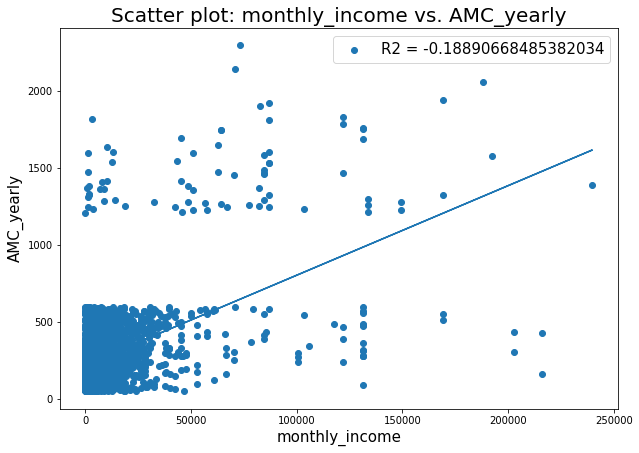

In [55]:
feature1 = 'monthly_income'
feature2 = 'AMC_yearly'
x = meta_df_winter[feature1]
y = AMC_df_winter[feature2]

r2 = r2_score(x, y)
print(f"R2 = {r2}")

x_label = feature1
y_label = feature2

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

fig, ax = plt.subplots(figsize =(10, 7))


plt.scatter(x, y, label = "R2 = " + str(r2))
plt.plot(x, mymodel)
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + x_label + " vs. " + y_label)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
# ax.set_ylim(0,20)
plt.legend(prop = {'size':15})
# ax.set_yscale(scale)
# ax.set_xscale(scale)
plt.show()



### On median points

In [123]:
# Create binned dataset
df = pd.DataFrame()
df = pd.merge(df2_filtered['Morning'], meta_df_filtered, left_index=True, right_index=True)


bins = np.arange(0,1000,100)

df['bins'] = pd.cut(df.floor_area, bins=bins,  right=False, include_lowest=True)

sigma1_median = df.groupby(['bins'])['sigma1'].median() # Calculate median sigma value for each bin
sigma_1_DF = sigma1_median.to_frame() 
sigma_1_DF['bins'] = np.arange(0,900,100)

In [52]:

# # import statsmodels.api as sm

# # fit regression model
# model = LinearRegression()
# y, X = sigma_1_DF['sigma1'], sigma_1_DF['bins']

# X = np.array(X.values.tolist())
# y = np.array(y.values.tolist())

# X = X.reshape(-1,1)

# model.fit(X, y) # Linear Regression model

# #display adjusted R-squared
# r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

# # x = sigma_1_DF['bins']
# # y = sigma_1_DF['sigma1']

# x_label = meta_df_filtered.columns[0]
# y_label = df2_filtered['Morning'].columns[0]

# fig, ax = plt.subplots(figsize =(10, 7))

# plt.scatter(x, y, label = "R-squared = " + str('{0:.3g}'.format(r2)))
# plt.plot(x, model.predict(y).reshape(-1,1))
# plt.rc('axes', titlesize=20) 
# plt.rc('axes', labelsize=15)
# plt.title("Scatter plot: " + x_label + " vs. " + y_label)
# ax.set_xlabel(x_label)
# ax.set_ylabel(y_label)
# ax.set_ylim(0,2)
# plt.legend(prop = {'size':15})
# # ax.set_yscale(scale)
# # ax.set_xscale(scale)
# plt.show()

In [223]:
temp = meta_df_filtered.loc[~(meta_df_filtered['monthly_income'] == 0.0)] # filter out all households with R0 monthly income, Treat as incorrectly filled in questionaire

temp_df = pd.merge(meta_df_filtered['monthly_income'], df2['Morning']['sigma1'], left_index=True, right_index=True)

In [225]:
# # Bin the data frame by "a" with 10 bins...
# bins = np.linspace(temp_df.monthly_income.min(), temp_df.monthly_income.max(), 10)
# groups = temp_df.groupby(np.digitize(temp_df.monthly_income, bins))

# # Get the mean of each bin:
# print(groups.mean().sigma1) # Also could do "groups.aggregate(np.mean)"

# # Similarly, the median:
# print(groups.median().sigma1)

# # # Apply some arbitrary function to aggregate binned data
# # print(groups.aggregate(lambda x: np.mean(x[x > 0.5])))

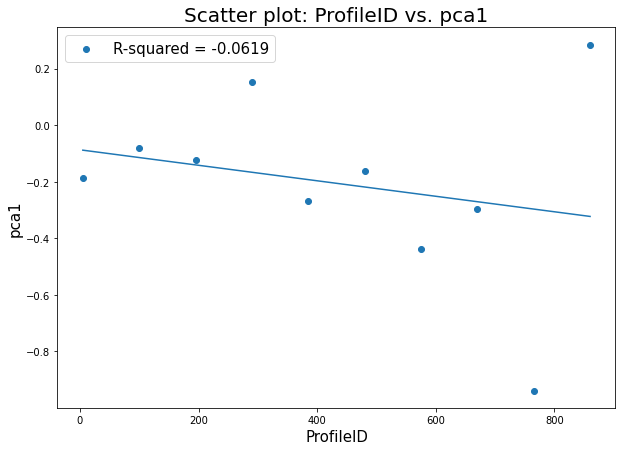

Morning


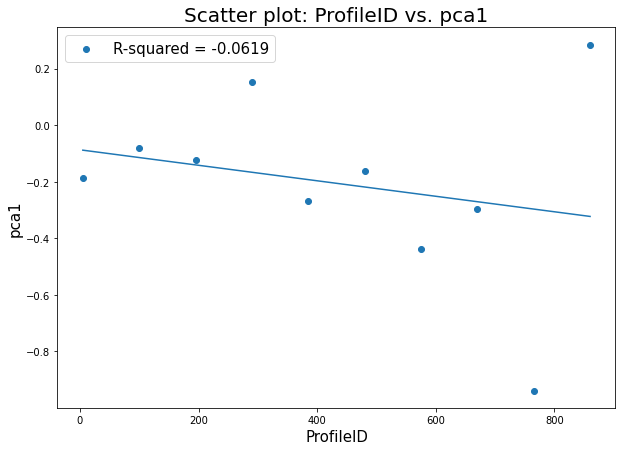

Morning


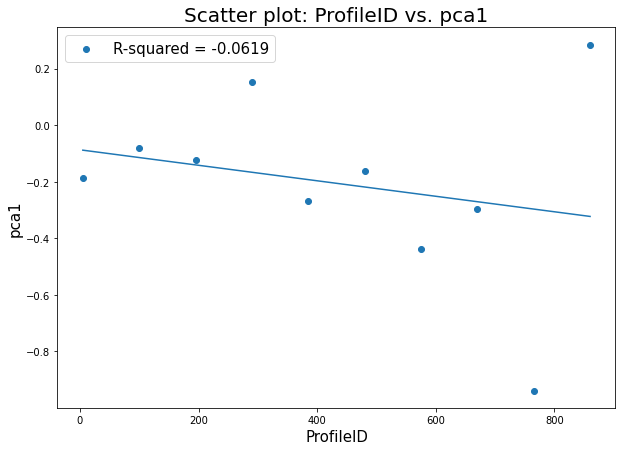

Morning


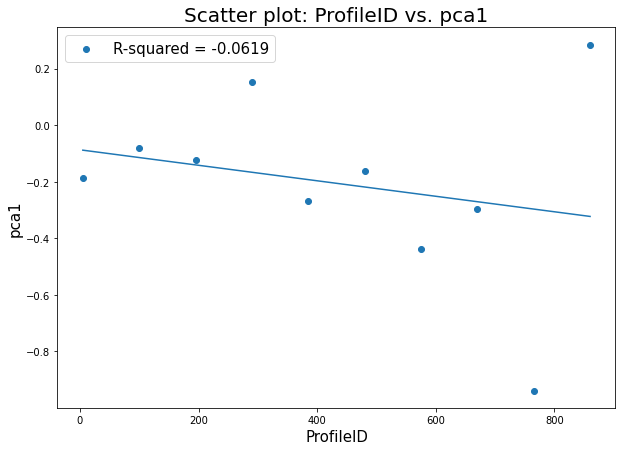

Morning


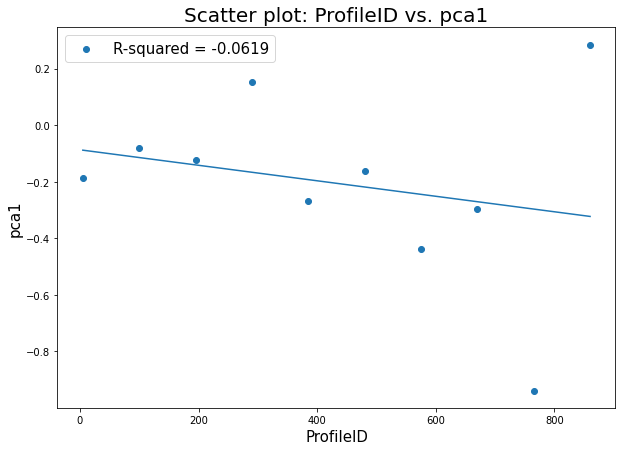

Afternoon


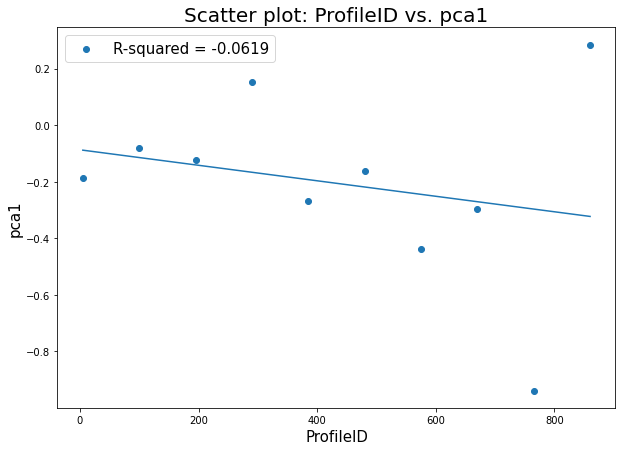

Afternoon


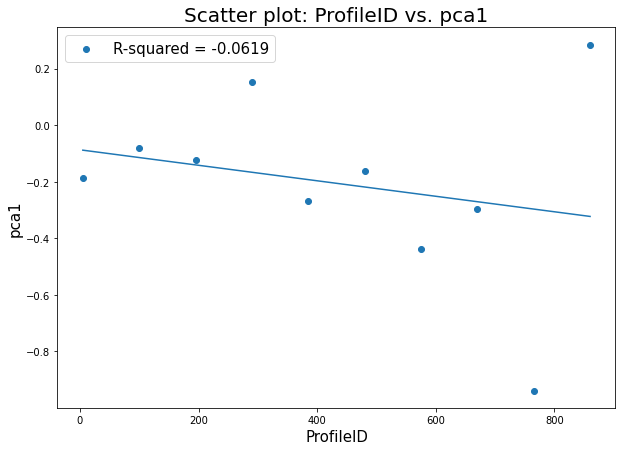

Afternoon


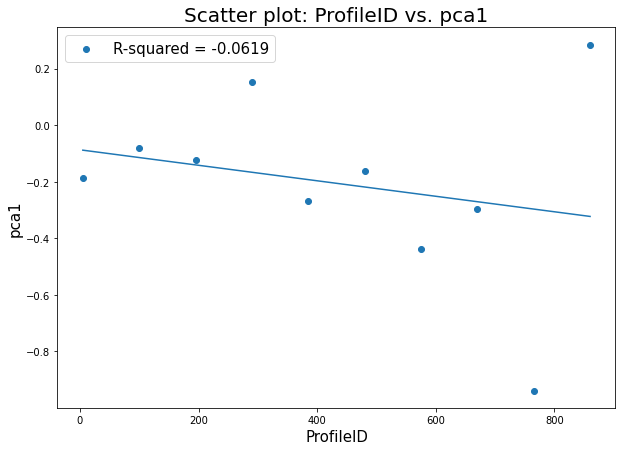

Afternoon


In [300]:
column_string = ['monthly_income', 'floor_area']

for day,j in df2_filtered:

    for column in column_string:
    
        temp_df = pd.merge(meta_df_filtered[column], df2[day][j], left_index=True, right_index=True)

        # temp_df = pd.merge(meta_df_filtered['monthly_income'], df2[day][j], left_index=True, right_index=True)

        # Bin the data frame by "a" with 10 bins...
        bins = np.linspace(temp_df[column].min(), temp_df[column].max(), 10)
        groups = temp_df.groupby(np.digitize(temp_df[column], bins))
        
        # fit regression model
        model = LinearRegression()
        # y, X = sigma_1_DF['sigma1'], sigma_1_DF['bins']

        # X = np.array(X.values.tolist())
        # y = np.array(y.values.tolist())
        y = groups.median()[j]
        X = bins

        X = X.reshape(-1,1)

        model.fit(X, y) # Linear Regression model

        #display adjusted R-squared
        r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

        x_label = temp_df.columns[0]
        y_label = temp_df.columns[1]

        fig, ax = plt.subplots(figsize =(10, 7))

        plt.scatter(X, y, label = "R-squared = " + str('{0:.3g}'.format(r2)))
        plt.plot(X, model.predict(X))
        plt.rc('axes', titlesize=20) 
        plt.rc('axes', labelsize=15)
        plt.title("Scatter plot: " + x_label + " vs. " + y_label)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # ax.set_ylim(0,2)
        plt.legend(prop = {'size':15})
        # ax.set_yscale(scale)
        # ax.set_xscale(scale)
        plt.show()


        print(day)

        # Morning
        # # Save the figure
        # fig.savefig("/thesis_project/Figures/regression/" + day + "/" +j +"vs" + column + ".png", bbox_inches='tight')
        fig.savefig(day + "_" +j +"vs" + column + ".png", bbox_inches='tight')

# Regression on AMC vs meatdata 10 bins

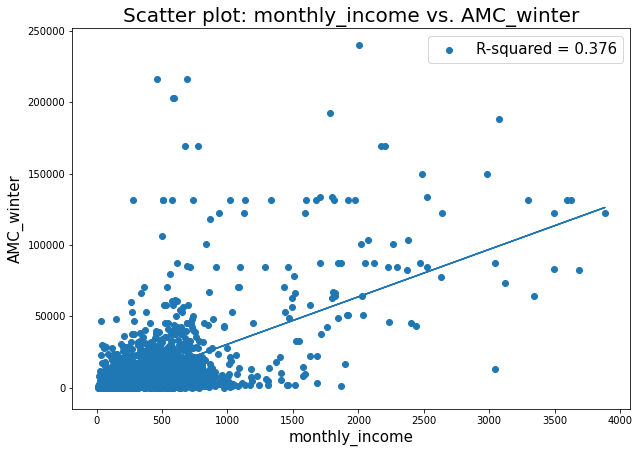

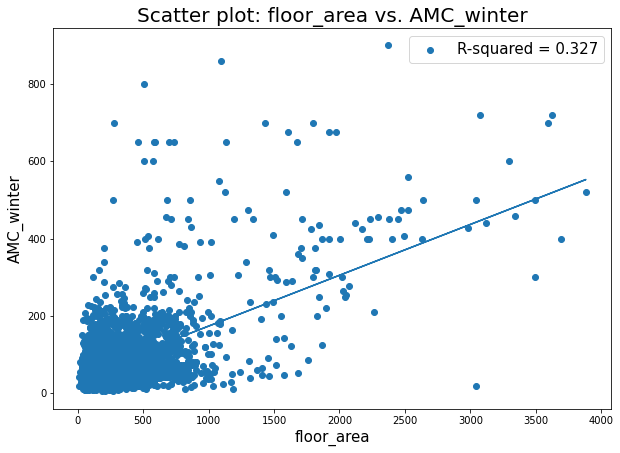

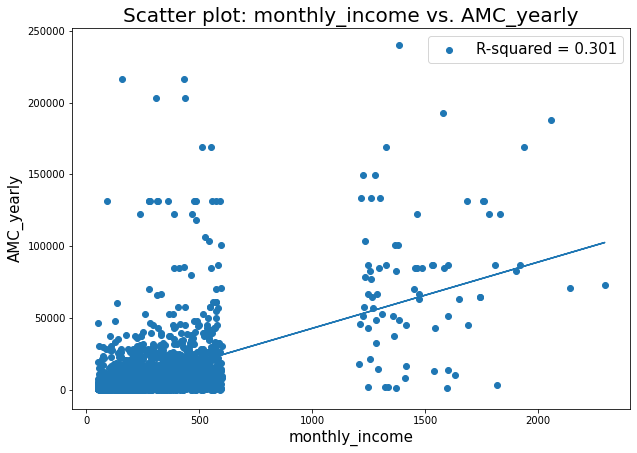

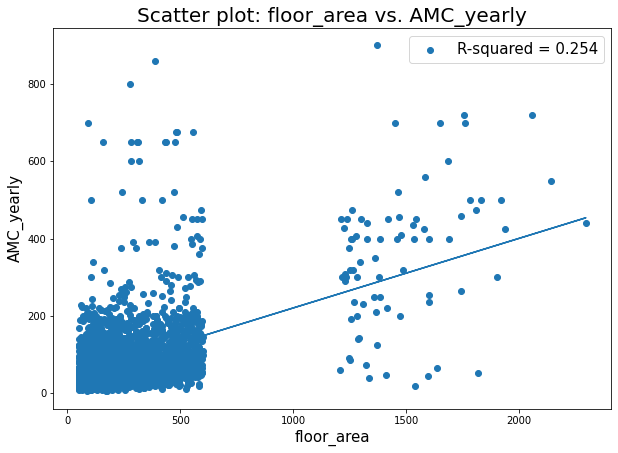

In [51]:
column_string = ['monthly_income', 'floor_area']

for j in AMC_df_filtered:

    for column in column_string:
    
        temp_df = pd.merge(meta_df_winter[column], AMC_df_filtered[j], left_index=True, right_index=True)

        # temp_df = pd.merge(meta_df_filtered['monthly_income'], df2[day][j], left_index=True, right_index=True)

        # Bin the data frame by "a" with 10 bins...
        bins = np.linspace(temp_df[column].min(), temp_df[column].max(), 10)
        groups = temp_df.groupby(np.digitize(temp_df[column], bins))
        
        # fit regression model
        model = LinearRegression()
        y, X = temp_df[column], temp_df[j]

        X = np.array(X.values.tolist())
        y = np.array(y.values.tolist())
        # y = groups.median()[j]
        # X = bins

        X = X.reshape(-1,1)

        model.fit(X, y) # Linear Regression model

        #display adjusted R-squared
        r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

        x_label = temp_df.columns[0]
        y_label = temp_df.columns[1]

        fig, ax = plt.subplots(figsize =(10, 7))

        plt.scatter(X, y, label = "R-squared = " + str('{0:.3g}'.format(r2)))
        plt.plot(X, model.predict(X))
        plt.rc('axes', titlesize=20) 
        plt.rc('axes', labelsize=15)
        plt.title("Scatter plot: " + x_label + " vs. " + y_label)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # ax.set_ylim(0,2)
        plt.legend(prop = {'size':15})
        # ax.set_yscale(scale)
        # ax.set_xscale(scale)
        plt.show()


        # print(day)

        # Morning
        # # Save the figure
        # fig.savefig("/thesis_project/Figures/regression/" + day + "/" +j +"vs" + column + ".png", bbox_inches='tight')
        fig.savefig("LR_" + x_label + "vs" + y_label + ".png", bbox_inches='tight')

# Multiple Linear Regression

In [194]:
columns = ['R-squared','']

pd.DataFrame(index = list_combinations[1:])

""
"(floor_area,)"
"(monthly_income,)"
"(roof_material_ENC,)"
"(water_access_ENC,)"
"(wall_material_ENC,)"
...
"(floor_area, monthly_income, roof_material_ENC, wall_material_ENC, years_electrified, total_residents)"
"(floor_area, monthly_income, water_access_ENC, wall_material_ENC, years_electrified, total_residents)"
"(floor_area, roof_material_ENC, water_access_ENC, wall_material_ENC, years_electrified, total_residents)"
"(monthly_income, roof_material_ENC, water_access_ENC, wall_material_ENC, years_electrified, total_residents)"


In [18]:
from itertools import combinations

y_feature = 'AMC_yearly'
x_features = ['floor_area','monthly_income', 'roof_material_ENC','water_access_ENC', 'wall_material_ENC','years_electrified', 'total_residents']

list_combinations = list()
for n in range(len(x_features) + 1):
    list_combinations += list(combinations(x_features, n))

i = 1
for features in list_combinations[1:]:
    #Setting the value for X and Y
    x = encoded_df[list(features)]#
    y = encoded_df[y_feature]

    #Splitting the dataset
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)


    mlr = LinearRegression()  
    mlr.fit(x_train, y_train)

    #Intercept and Coefficient
    print("Intercept: ", mlr.intercept_)
    print("Coefficients:")
    list(zip(x, mlr.coef_))

    #Prediction of test set
    y_pred_mlr= mlr.predict(x_test)
    # y_pred_mlr = y_pred_mlr.reshape(-1)
    #Predicted values
    print("Prediction for test set: {}".format(y_pred_mlr))

    #Actual value and the predicted value
    mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
    mlr_diff.head()

    #Model Evaluation
    from sklearn import metrics
    meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
    meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
    print('R squared: {:.2f}'.format(mlr.score(x,y)*100))
    print('Mean Absolute Error:', meanAbErr)
    print('Mean Square Error:', meanSqErr)
    print('Root Mean Square Error:', rootMeanSqErr)

    rows = [['y_features:', 'x_features: '],
            [y_feature,list(features)],
            ['Intercept', mlr.intercept_],
            ['R-squared', mlr.score(x,y)*100],
            ['MAE', meanAbErr],
            ['MSE', meanSqErr],
            ['RMSE', rootMeanSqErr]]

    # from the numpy module
    np.savetxt('mlr_results_AMC_yearly' + str(i)  +'.csv', 
            rows,
            delimiter ="; ", 
            fmt ='% s')
    
    i = i + 1

# # Save results
# import csv
# # x_feature = '\',\''.join(x_features)
# with open('mlr_results' + y_feature +'.csv', 'wb') as csvfile:
#     filewriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     filewriter.writerow([y_feature, 'x_features:', ])
#     filewriter.writerow(['Intercept', mlr.intercept_])
#     filewriter.writerow(['R-squared', mlr.score(x,y)*100])
#     filewriter.writerow(['MAE', meanAbErr])
#     filewriter.writerow(['MSE', meanSqErr])
#     filewriter.writerow(['RMSE', rootMeanSqErr])

Intercept:  139.85385712644262
Coefficients:
Prediction for test set: [276.73049198 328.59953255 246.47355164 ... 217.65741799 298.34259222
 250.79597169]
R squared: 25.62
Mean Absolute Error: 150.47432066041654
Mean Square Error: 51535.61150413009
Root Mean Square Error: 227.0145623173326
Intercept:  207.77303140399383
Coefficients:
Prediction for test set: [269.25946525 245.28848301 219.44282314 ... 223.9657167  218.22191936
 219.36556452]
R squared: 28.69
Mean Absolute Error: 144.01862868876103
Mean Square Error: 51876.56855859125
Root Mean Square Error: 227.76428288603825
Intercept:  197.33801791232713
Coefficients:
Prediction for test set: [266.09989142 266.09989142 266.09989142 ... 266.09989142 266.09989142
 317.67129655]
R squared: 2.44
Mean Absolute Error: 160.9115959743479
Mean Square Error: 65624.69167931928
Root Mean Square Error: 256.1731673679335
Intercept:  92.43268560440433
Coefficients:
Prediction for test set: [252.79927078 252.79927078 332.98256337 ...  92.4326856  25

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

 218.1259983638733
Coefficients:
Prediction for test set: [262.1760555  238.09183111 212.12407286 ... 222.57728215 210.89740136
 223.8643472 ]
R squared: 28.70
Mean Absolute Error: 144.21164653799755
Mean Square Error: 51961.99178802824
Root Mean Square Error: 227.95173126788978
Intercept:  164.55099245936003
Coefficients:
Prediction for test set: [286.86004552 232.67690642 345.17673987 ... 193.86581843 187.95311184
 227.06826379]
R squared: 31.04
Mean Absolute Error: 139.72713326805987
Mean Square Error: 50157.58038253117
Root Mean Square Error: 223.95888100839218
Intercept:  198.87582121550415
Coefficients:
Prediction for test set: [281.86819814 245.03149386 214.8449637  ... 225.77886117 215.75306964
 212.63489319]
R squared: 28.79
Mean Absolute Error: 143.95137984709734
Mean Square Error: 51772.85285135143
Root Mean Square Error: 227.5364868572762
Intercept:  42.68915178065356
Coefficients:
Prediction for test set: [251.04221383 251.04221383 328.01814946 ...  97.09034259 251.0422138

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

 125.84884926868631
Coefficients:
Prediction for test set: [274.01701066 324.82762197 244.3774874  ... 217.60193303 295.1880987
 265.3485507 ]
R squared: 25.69
Mean Absolute Error: 150.3573009278659
Mean Square Error: 51626.625094355506
Root Mean Square Error: 227.21493149517156
Intercept:  80.10842451008912
Coefficients:
Prediction for test set: [290.40967156 316.60780232 353.35032423 ... 192.8590488  272.4752899
 276.63340382]
R squared: 27.48
Mean Absolute Error: 147.3472592770637
Mean Square Error: 50165.858072774114
Root Mean Square Error: 223.97736062551974
Intercept:  122.1773091940513
Coefficients:
Prediction for test set: [277.72120389 326.53944815 245.44526961 ... 218.21391772 296.57572047
 262.98692072]
R squared: 25.70
Mean Absolute Error: 150.32949656626295
Mean Square Error: 51593.34889790026
Root Mean Square Error: 227.14169343803937
Intercept:  25.319408273495725
Coefficients:
Prediction for test set: [256.80541271 304.11877038 290.88441117 ...  85.13904236 276.51931174

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

 34.573156165772986
Coefficients:
Prediction for test set: [255.42188853 248.53263218 356.12731603 ...  94.36239211 244.59591427
 371.19781379]
R squared: 13.90
Mean Absolute Error: 140.59785482077092
Mean Square Error: 57743.46136138142
Root Mean Square Error: 240.2986919676872
Intercept:  16.758748360154783
Coefficients:
Prediction for test set: [279.26600669 250.11592226 319.57169529 ...  96.62933399 245.25757486
 356.39748435]
R squared: 14.13
Mean Absolute Error: 140.37921642894773
Mean Square Error: 57544.84145085025
Root Mean Square Error: 239.88505883203783
Intercept:  161.0053203005743
Coefficients:
Prediction for test set: [277.663467   255.57957643 359.68934625 ... 244.04249452 242.96021039
 330.32126572]
R squared: 3.93
Mean Absolute Error: 157.69610127497043
Mean Square Error: 64322.734636699046
Root Mean Square Error: 253.619271027852
Intercept:  196.8296700674612
Coefficients:
Prediction for test set: [266.15429338 267.02432077 267.3143299  ... 266.12777143 267.16932533


C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

Intercept:  16.195472666321365
Coefficients:
Prediction for test set: [255.3456105  301.96707019 289.45706844 ...  85.94600373 274.77121871
 315.29680701]
R squared: 32.43
Mean Absolute Error: 136.90981255257543
Mean Square Error: 47241.55706224559
Root Mean Square Error: 217.3512297233342
Intercept:  -8.20622361138453
Coefficients:
Prediction for test set: [271.66589994 305.44345014 350.50757792 ...  83.29097016 270.39834466
 312.69437764]
R squared: 32.93
Mean Absolute Error: 136.0748993232521
Mean Square Error: 46716.6747571927
Root Mean Square Error: 216.14040519345915
Intercept:  -14.903146106152121
Coefficients:
Prediction for test set: [287.84567458 308.78904285 289.25413259 ...  88.24528922 277.38820723
 297.90554407]
R squared: 32.79
Mean Absolute Error: 136.25984107971885
Mean Square Error: 46754.23961691024
Root Mean Square Error: 216.22728693879097
Intercept:  85.08352733884914
Coefficients:
Prediction for test set: [286.22664622 312.19541402 350.14857737 ... 191.79662721 2

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

Intercept:  42.235467509666506
Coefficients:
Prediction for test set: [248.20167711 240.96066648 350.71211523 ...  91.64684068 236.82294613
 377.66955635]
R squared: 13.93
Mean Absolute Error: 140.3459812854954
Mean Square Error: 57772.24464957221
Root Mean Square Error: 240.35857515298306
Intercept:  24.03062865219087
Coefficients:
Prediction for test set: [272.47479061 243.92548548 314.03127073 ...  94.48975375 239.16726796
 361.95080099]
R squared: 14.14
Mean Absolute Error: 140.16520230535838
Mean Square Error: 57584.83612310371
Root Mean Square Error: 239.96840651032318
Intercept:  8.070457222215794
Coefficients:
Prediction for test set: [284.12585657 247.51476604 348.47994562 ...  93.8084133  238.53504898
 358.70292522]
R squared: 14.33
Mean Absolute Error: 139.59595933134733
Mean Square Error: 57314.64369111417
Root Mean Square Error: 239.4047695663438
Intercept:  159.23092791939968
Coefficients:
Prediction for test set: [279.90671951 255.58632157 359.17704977 ... 244.3369935  2

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

 -7.109691970797485
Coefficients:
Prediction for test set: [288.60107541 299.76484598 334.69994668 ...  79.28545264 260.60640368
 295.9331048 ]
R squared: 33.28
Mean Absolute Error: 135.1546573185422
Mean Square Error: 46257.95034872108
Root Mean Square Error: 215.07661506709903
Intercept:  87.39007068291534
Coefficients:
Prediction for test set: [258.75894215 214.43551632 338.43288218 ... 106.72649903 176.73892495
 286.85621783]
R squared: 34.74
Mean Absolute Error: 131.56247630485186
Mean Square Error: 47523.02868883753
Root Mean Square Error: 217.99777221072128
Intercept:  81.47120127124279
Coefficients:
Prediction for test set: [276.92997077 224.573784   243.60967515 ... 115.1844951  195.16549457
 266.9946558 ]
R squared: 34.08
Mean Absolute Error: 132.39840707773004
Mean Square Error: 47789.50656996275
Root Mean Square Error: 218.60811185764072
Intercept:  42.644337805051464
Coefficients:
Prediction for test set: [304.8885886  227.99963341 340.32875851 ... 111.2737434  185.1663017

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

Intercept:  58.04580763122297
Coefficients:
Prediction for test set: [290.5194177  214.05257834 330.68997016 ... 106.4207625  170.87651239
 272.57300099]
R squared: 35.27
Mean Absolute Error: 130.62466430129385
Mean Square Error: 46978.86439855968
Root Mean Square Error: 216.74608277558255
Intercept:  26.926601319485684
Coefficients:
Prediction for test set: [291.79622815 248.53730423 331.94536411 ...  96.32908223 201.3491817
 274.45514963]
R squared: 37.77
Mean Absolute Error: 129.61092526340278
Mean Square Error: 45105.51973530259
Root Mean Square Error: 212.3806011275573


C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

## PCA on sigma data

In [280]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

x = df2_filtered['Morning'][['sigma1','sigma2']]

principalComponents = pca.fit_transform(x)

e_dataframe=pd.DataFrame(principalComponents,columns = ['pca1']) 
temp_df2 = temp_df.reset_index()
temp_df2  = pd.merge(temp_df2,e_dataframe, right_index=True, left_index=True)